In [136]:
# https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/how-time-series-cross-correlation-works.htm

from __future__ import annotations

#os packages
import os
import itertools
import glob
import tempfile
import time
from pathlib import Path

#Data Packages
import numpy as np
import dask.array as da
import xarray as xr

#xarray parellel
from distributed import Client
Client()

import xclim as xc

xr.set_options(display_style="html")

import pandas as pd

#Stats Packages

#Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from matplotlib import gridspec, colors, colormaps, cm, ticker

# deprecated   import lcc_plotting_functs as lcc_pf     #.py file containing plotting functions for LCC gridline ticks

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

from datetime import datetime, timedelta

#MPL inline magic
%matplotlib inline

# Output folder
output_folder = Path(tempfile.mkdtemp())

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44821 instead
  warnings.warn(


In [137]:
#set up a dask env. 
from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
client = Client(n_workers=2, threads_per_worker=4, memory_limit="64GB") #mem limit * n_workers = total memory allocated
client

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39549 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39549/status,
Dashboard: http://127.0.0.1:39549/status,Workers: 2
Total threads: 8,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37273,Workers: 2
Dashboard: http://127.0.0.1:39549/status,Total threads: 8
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:45652,Total threads: 4
Dashboard: http://127.0.0.1:34737/status,Memory: 59.60 GiB
Nanny: tcp://127.0.0.1:46865,


In [138]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path0 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_hist/*1p000.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files0 = glob.glob(path0, recursive=True)
files0.sort()
files_to_open0 = files0
print(f' Number of files in dataset {len(files_to_open0)}')

 Number of files in dataset 15


In [205]:
# Path, you can do a lot with regex here to select what files to read in to begin with. 
#    For monthly the pattern is: *-01-* . ranges: *-0[1-3]-* (Jan 1 thru Mar 31) 
path1 = "/home/sleake/AFWA_TOTPRECIP_PrecipDays_eoc_4p5/*1p000.nc"
#path = "/home/scratch/ahaberlie/AFWA_TOTPRECIP/end_of_century_8p5/*/*-07-*.nc"

files1 = glob.glob(path1, recursive=True)
files1.sort()
files_to_open1 = files1
print(f' Number of files in dataset {len(files_to_open1)}')

 Number of files in dataset 15


In [206]:
path_grid = r"/home/sleake/WRF-BCC_Geogrid"
grid = xr.open_dataset(os.path.join(path_grid,"geo_em.d01.nc"))

In [207]:

da0 = xr.open_mfdataset(files_to_open0,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')
da0 = da0.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da0 = da0.rename({"Time":"time"})

'''

da0 = xr.open_mfdataset(files_to_open0,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')

da0 = da0.rename({'y': 'south_north', 'x': 'west_east', 'latitude': 'lat', 'longitude': 'lon'})
'''

"\n\nda0 = xr.open_mfdataset(files_to_open0,\n                       chunks='auto',\n                       combine='by_coords',\n                       engine='netcdf4')\n\nda0 = da0.rename({'y': 'south_north', 'x': 'west_east', 'latitude': 'lat', 'longitude': 'lon'})\n"

In [208]:
da1 = xr.open_mfdataset(files_to_open1,
                       chunks='auto',
                       combine='by_coords',
                       engine='netcdf4')

da1 = da1.assign_coords(lon=grid.CLONG[0], lat=grid.CLAT[0])

da1 = da1.rename({"Time":"time"})

In [209]:
da0

,Array,Chunk
Bytes,6.42 GiB,127.65 MiB
Shape,"(5478, 899, 1399)","(242, 596, 928)"
Count,1553 Tasks,480 Chunks
Type,bool,numpy.ndarray


In [210]:
da1

,Array,Chunk
Bytes,6.42 GiB,127.65 MiB
Shape,"(5477, 899, 1399)","(242, 596, 928)"
Count,1551 Tasks,480 Chunks
Type,bool,numpy.ndarray


In [211]:
factor = 21
da0 = da0.coarsen(south_north=factor, west_east=factor, boundary='trim').mean()
da1 = da1.coarsen(south_north=factor, west_east=factor, boundary='trim').mean()

In [212]:
da0

<xarray.Dataset>
Dimensions:         (time: 5478, south_north: 42, west_east: 66)
Coordinates:
    lon             (south_north, west_east) float32 -121.6 -120.9 ... -62.91
    lat             (south_north, west_east) float32 20.9 21.08 ... 48.6 48.35
  * time            (time) datetime64[ns] 1990-10-01T12:00:00 ... 2005-09-29T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) float64 dask.array<chunksize=(242, 28, 44), meta=np.ndarray>
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Tue Sep  8 08:07:31 2020: ncks -O -x -v ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...

In [213]:
da1

<xarray.Dataset>
Dimensions:         (time: 5477, south_north: 42, west_east: 66)
Coordinates:
    lon             (south_north, west_east) float32 -121.6 -120.9 ... -62.91
    lat             (south_north, west_east) float32 20.9 21.08 ... 48.6 48.35
  * time            (time) datetime64[ns] 2085-10-01T12:00:00 ... 2100-09-29T...
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (time, south_north, west_east) float64 dask.array<chunksize=(242, 28, 44), meta=np.ndarray>
Attributes: (12/87)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2085-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Sat Jun 19 14:27:39 2021: ncks -O -x -v ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...

In [214]:
wet_day_threshold = 0.0
wet_days0 = da0.AFWA_TOTPRECIP > wet_day_threshold
wet_days1 = da1.AFWA_TOTPRECIP > wet_day_threshold


In [215]:
def consecutive_wet_days(wet_days_array, min_days):
    """
    Returns a boolean array where True indicates that the day is part of a run of
    at least `min_days` consecutive wet days.
    """
    # Convert xarray.DataArray to numpy array for processing
    wet_days_np = wet_days_array.values
    
    # Initialize the mask with False
    consecutive_mask = np.zeros_like(wet_days_np, dtype=bool)
    
    # Iterate over each spatial location
    for i in range(wet_days_np.shape[1]):  # south_north dimension
        for j in range(wet_days_np.shape[2]):  # west_east dimension
            # Extract the time series for the current spatial location
            time_series = wet_days_np[:, i, j]
            
            # Create a temporary mask for consecutive wet days
            temp_mask = np.zeros_like(time_series, dtype=bool)
            
            # Track consecutive wet days
            count = 0
            for t in range(len(time_series)):
                if time_series[t]:
                    count += 1
                    if count >= min_days:
                        temp_mask[t - min_days + 1:t + 1] = True
                else:
                    count = 0
            
            # Update the mask for the spatial location
            consecutive_mask[:, i, j] = temp_mask
    
    return xr.DataArray(consecutive_mask, dims=wet_days_array.dims, coords=wet_days_array.coords)


In [216]:
min_consecutive_days = 2  # Set your desired number of consecutive days
consecutive_wet_mask0 = consecutive_wet_days(wet_days0, min_consecutive_days)
consecutive_wet_mask1 = consecutive_wet_days(wet_days1, min_consecutive_days)


In [217]:
consecutive_wet_mask0

<xarray.DataArray (time: 5478, south_north: 42, west_east: 66)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ..., False, False,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ..., False, False,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False,  True]],

       [[False, False, False, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
    lon      (south_north, west_east) float32 -121.6 -120.9 ... -63.9 -62.91
    lat      (south_north, west_east) float32 20.9 21.08 21.24 ... 48.6 48.35
  * time     (time) datetime64[ns] 1990-10-01T12:00:00 ... 2005-09-29T12:00:00
Dimensions without coordinates: south_north, west_east

In [218]:
consecutive_wet_mask1

<xarray.DataArray (time: 5477, south_north: 42, west_east: 66)>
array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False, False]],

       [[False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
...
        ...,
        [ True,  True, False, ...,  True,  True,  True],
        [False,  True, False, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [False,  True,  True, ...,  True, False, False],
        [False,  True,  True, ..., False,  True, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False,  True]],

       [[ True,  True,  True, ..., False, False, False],
        [False,  True,  True, ...,  True, False, False],
        [False,  True,  True, ..., False,  True, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
    lon      (south_north, west_east) float32 -121.6 -120.9 ... -63.9 -62.91
    lat      (south_north, west_east) float32 20.9 21.08 21.24 ... 48.6 48.35
  * time     (time) datetime64[ns] 2085-10-01T12:00:00 ... 2100-09-29T12:00:00
Dimensions without coordinates: south_north, west_east

In [227]:
def extract_and_aggregate_mam(ds: xr.Dataset, time_var: str = 'time', output_file: str = None) -> xr.DataArray:
    """
    Extracts daily values for March, April, and May from an xarray Dataset, aggregates by day, and optionally saves the result.
    
    Parameters:
    - ds (xr.Dataset): The input xarray dataset.
    - time_var (str): The name of the time dimension in the dataset.
    - output_file (str): Optional path to save the resulting dataset as a NetCDF file.
    
    Returns:
    - xr.DataArray: The daily aggregated data for March, April, and May.
    """
    # Ensure the time variable is a DateTimeIndex
    if not pd.api.types.is_datetime64_any_dtype(ds[time_var].values):
        ds[time_var] = pd.to_datetime(ds[time_var].values)
    
    # Slice to get data for March, April, and May
    selected_months = ds.sel({time_var: ds[time_var].dt.month.isin([3,4,5])})
    
    # Aggregate over years, keeping day of the year
    daily_data = selected_months.groupby(f'{time_var}.dayofyear').mean()
    
    # Save the result if an output file path is provided
    if output_file:
        daily_data.to_netcdf(output_file)
    
    return daily_data

In [228]:
da0_cleaned = extract_and_aggregate_mam(consecutive_wet_mask0, time_var='time', output_file='daily_data_mam.nc')
da1_cleaned = extract_and_aggregate_mam(consecutive_wet_mask1, time_var='time', output_file='daily_data_mam.nc')

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [229]:
da0_cleaned

<xarray.DataArray (dayofyear: 93, south_north: 42, west_east: 66)>
array([[[0.09090909, 0.09090909, 0.09090909, ..., 0.        ,
         0.        , 0.        ],
        [0.18181818, 0.18181818, 0.18181818, ..., 0.        ,
         0.        , 0.        ],
        [0.09090909, 0.18181818, 0.27272727, ..., 0.27272727,
         0.09090909, 0.        ],
        ...,
        [0.09090909, 0.        , 0.27272727, ..., 0.54545455,
         0.45454545, 0.54545455],
        [0.09090909, 0.        , 0.45454545, ..., 0.45454545,
         0.45454545, 0.45454545],
        [0.09090909, 0.27272727, 0.54545455, ..., 0.54545455,
         0.36363636, 0.36363636]],

       [[0.06666667, 0.13333333, 0.13333333, ..., 0.13333333,
         0.06666667, 0.06666667],
        [0.13333333, 0.26666667, 0.2       , ..., 0.2       ,
         0.06666667, 0.13333333],
        [0.        , 0.26666667, 0.33333333, ..., 0.26666667,
         0.13333333, 0.06666667],
...
        [0.2       , 0.26666667, 0.26666667, ..., 0.46666667,
         0.33333333, 0.4       ],
        [0.13333333, 0.26666667, 0.33333333, ..., 0.46666667,
         0.46666667, 0.46666667],
        [0.13333333, 0.4       , 0.4       , ..., 0.46666667,
         0.33333333, 0.33333333]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.25      , 0.5       , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.25      , 0.25      , 0.5       , ..., 0.25      ,
         0.        , 0.        ],
        ...,
        [0.25      , 0.25      , 0.25      , ..., 0.75      ,
         0.5       , 0.5       ],
        [0.25      , 0.25      , 0.25      , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.25      , 0.25      , 0.25      , ..., 0.5       ,
         0.5       , 0.5       ]]])
Coordinates:
    lon        (south_north, west_east) float32 -121.6 -120.9 ... -63.9 -62.91
    lat        (south_north, west_east) float32 20.9 21.08 21.24 ... 48.6 48.35
  * dayofyear  (dayofyear) int64 60 61 62 63 64 65 ... 147 148 149 150 151 152
Dimensions without coordinates: south_north, west_east

In [230]:
baseline_da = da0_cleaned
future_da = da1_cleaned

In [231]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.signal import correlate

def compute_cross_correlation(baseline_da, future_da):
    # Convert DataArrays to numpy arrays for correlation computation
    baseline_array = baseline_da.values
    future_array = future_da.values
    
    # Initialize the correlation array
    correlation = np.full((baseline_array.shape[1], baseline_array.shape[2]), np.nan)
    
    # Compute cross-correlation for each grid cell
    for i in range(baseline_array.shape[1]):
        for j in range(baseline_array.shape[2]):
            baseline_series = baseline_array[:, i, j]
            future_series = future_array[:, i, j]
            corr = correlate(baseline_series, future_series, mode='full')
            correlation[i, j] = np.max(corr)
    
    # Create DataArray with the correct dimensions and coordinates
    return xr.DataArray(correlation, coords=[baseline_da.south_north.values, baseline_da.west_east.values], dims=["south_north", "west_east"])

def compute_lag(baseline_da, future_da):
    baseline_array = baseline_da.values
    future_array = future_da.values
    
    # Initialize the lag array
    lags = np.full((baseline_array.shape[1], baseline_array.shape[2]), np.nan)
    
    # Compute cross-correlation and lag for each grid cell
    for i in range(baseline_array.shape[1]):
        for j in range(baseline_array.shape[2]):
            baseline_series = baseline_array[:, i, j]
            future_series = future_array[:, i, j]
            corr = correlate(baseline_series, future_series, mode='full')
            lag = np.arange(-len(baseline_series) + 1, len(baseline_series))
            lags[i, j] = lag[np.argmax(corr)]
    
    # Create DataArray with the correct dimensions and coordinates
    return xr.DataArray(lags, coords=[baseline_da.south_north.values, baseline_da.west_east.values], dims=["south_north", "west_east"])

def plot_correlation_and_lags(correlation, lags, lon, lat):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot 1: Correlation plot (blue-red colormap)
    corr_plot = ax1.pcolormesh(lon, lat, correlation, transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1, vmax=1)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    ax1.set_title('Absolute Correlations (CWD)')
    fig.colorbar(corr_plot, ax=ax1, orientation='vertical', label='Correlation')
    
    # Plot 2: Lag plot (-2 to +4 days, brown-blue-green colormap)
    lag_plot = ax2.pcolormesh(lon, lat, lags, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-10, vmax=10)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    ax2.set_title('Lag Times (Days)')
    fig.colorbar(lag_plot, ax=ax2, orientation='vertical', label='Lag (Days)')
    
    plt.tight_layout()
    plt.show()




In [232]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.signal import correlate

def apply_kernel(data, kernel, i, j):
    """Apply a 2D kernel around the (i, j) position in the data."""
    kernel_size = kernel.shape[0]
    offset = kernel_size // 2
    weighted_sum = 0
    total_weight = 0
    
    # Loop over the kernel
    for m in range(-offset, offset + 1):
        for n in range(-offset, offset + 1):
            if 0 <= i + m < data.shape[1] and 0 <= j + n < data.shape[2]:
                weighted_sum += data[:, i + m, j + n] * kernel[m + offset, n + offset]
                total_weight += kernel[m + offset, n + offset]
    
    return weighted_sum / total_weight

def compute_cross_correlation(baseline_da, future_da, kernel=None):
    # Convert DataArrays to numpy arrays for correlation computation
    baseline_array = baseline_da.values
    future_array = future_da.values
    
    # Initialize the correlation array
    correlation = np.full((baseline_array.shape[1], baseline_array.shape[2]), np.nan)
    
    # Normalize the kernel if provided
    if kernel is not None:
        kernel = kernel / np.sum(kernel)  # Normalize kernel
    
    # Compute cross-correlation for each grid cell (and spatial neighbors if kernel is provided)
    for i in range(baseline_array.shape[1]):
        for j in range(baseline_array.shape[2]):
            # Use kernel-weighted neighbors or just the central grid point
            if kernel is not None:
                baseline_series = apply_kernel(baseline_array, kernel, i, j)
                future_series = apply_kernel(future_array, kernel, i, j)
            else:
                baseline_series = baseline_array[:, i, j]
                future_series = future_array[:, i, j]
            
            # Calculate cross-correlation
            corr = correlate(baseline_series, future_series, mode='full')
            correlation[i, j] = np.max(corr)
    
    # Create DataArray with the correct dimensions and coordinates
    return xr.DataArray(correlation, coords=[baseline_da.south_north.values, baseline_da.west_east.values], dims=["south_north", "west_east"])

def compute_lag(baseline_da, future_da, kernel=None):
    baseline_array = baseline_da.values
    future_array = future_da.values
    
    # Initialize the lag array
    lags = np.full((baseline_array.shape[1], baseline_array.shape[2]), np.nan)
    
    # Normalize the kernel if provided
    if kernel is not None:
        kernel = kernel / np.sum(kernel)  # Normalize kernel
    
    # Compute lag for each grid cell (and spatial neighbors if kernel is provided)
    for i in range(baseline_array.shape[1]):
        for j in range(baseline_array.shape[2]):
            # Use kernel-weighted neighbors or just the central grid point
            if kernel is not None:
                baseline_series = apply_kernel(baseline_array, kernel, i, j)
                future_series = apply_kernel(future_array, kernel, i, j)
            else:
                baseline_series = baseline_array[:, i, j]
                future_series = future_array[:, i, j]
            
            # Calculate cross-correlation and corresponding lag
            corr = correlate(baseline_series, future_series, mode='full')
            lag = np.arange(-len(baseline_series) + 1, len(baseline_series))
            lags[i, j] = lag[np.argmax(corr)]
    
    # Create DataArray with the correct dimensions and coordinates
    return xr.DataArray(lags, coords=[baseline_da.south_north.values, baseline_da.west_east.values], dims=["south_north", "west_east"])

def plot_correlation_and_lags(correlation, lags, lon, lat):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot 1: Correlation plot (blue-red colormap)
    corr_plot = ax1.pcolormesh(lon, lat, correlation, transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1, vmax=1)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    ax1.set_title('Absolute Correlations (CWD)')
    fig.colorbar(corr_plot, ax=ax1, orientation='vertical', label='Correlation')
    
    # Plot 2: Lag plot (-10 to +10 days, brown-blue-green colormap)
    lag_plot = ax2.pcolormesh(lon, lat, lags, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-10, vmax=10)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    ax2.set_title('Lag Times (Days)')
    fig.colorbar(lag_plot, ax=ax2, orientation='vertical', label='Lag (Days)')
    
    plt.tight_layout()
    plt.show()

# Example kernel (3x3 with uniform weights of 1)
kernel = np.ones((3, 3))

# Example usage
# correlation = compute_cross_correlation(baseline_da, future_da, kernel=kernel)
# lags = compute_lag(baseline_da, future_da, kernel=kernel)

# Plotting
# plot_correlation_and_lags(correlation, lags, baseline_da.west_east.values, baseline_da.south_north.values)


Latitude range: 20.90405 to 52.581223
Longitude range: -132.68779 to -62.91488
Correlation shape: (42, 66)
Lag shape: (42, 66)


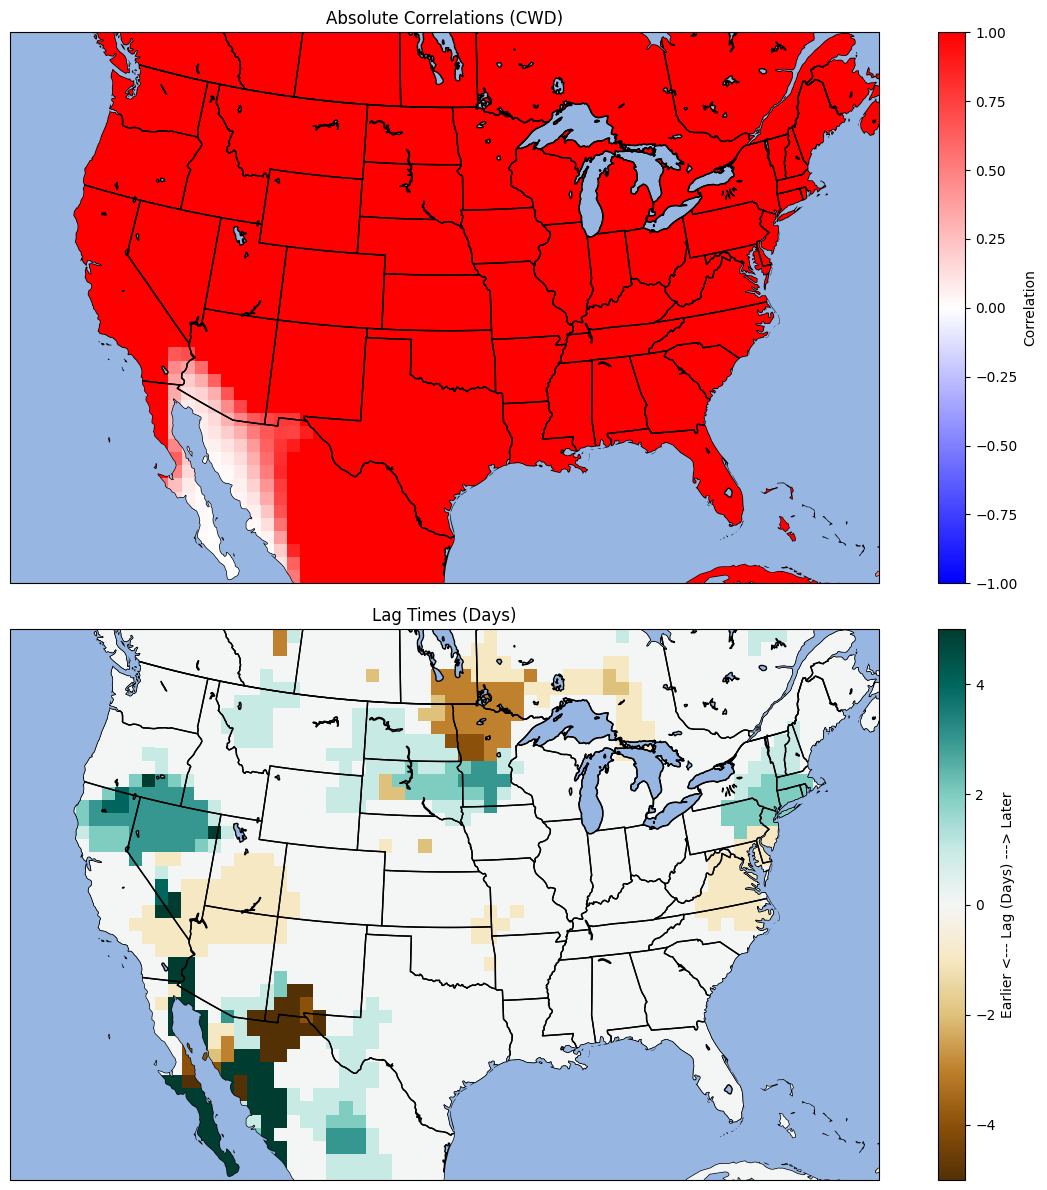

In [233]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_correlation_and_lags(correlation, lags, lon, lat):
    print("Latitude range:", lat.min(), "to", lat.max())
    print("Longitude range:", lon.min(), "to", lon.max())
    print("Correlation shape:", correlation.shape)
    print("Lag shape:", lags.shape)
    
    # Define the Lambert Conformal Conic projection centered on CONUS
    projection = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': projection})

    # Plot 1: Correlation plot
    corr_plot = ax1.pcolormesh(lon, lat, correlation, transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1, vmax=1)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_feature(cfeature.LAND, edgecolor='black')
    ax1.add_feature(cfeature.OCEAN, zorder=2)
    ax1.add_feature(cfeature.LAKES, edgecolor='black')
    ax1.add_feature(cfeature.STATES, edgecolor='black')
    ax1.set_title('Absolute Correlations (CWD)')
    fig.colorbar(corr_plot, ax=ax1, orientation='vertical', label='Correlation')

    # Plot 2: Lag plot
    lag_plot = ax2.pcolormesh(lon, lat, lags, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-5, vmax=5)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    ax2.add_feature(cfeature.LAND, edgecolor='black')
    ax2.add_feature(cfeature.OCEAN, zorder=2)
    ax2.add_feature(cfeature.LAKES, edgecolor='black')
    ax2.add_feature(cfeature.STATES, edgecolor='black')
    ax2.set_title('Lag Times (Days)')
    fig.colorbar(lag_plot, ax=ax2, orientation='vertical', label='Earlier <--- Lag (Days) ---> Later')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming baseline_da and future_da are your xarray DataArrays
# Compute cross-correlation and lag
correlation = compute_cross_correlation(baseline_da, future_da, kernel=kernel)
lags = compute_lag(baseline_da, future_da, kernel=kernel)

# Plotting
plot_correlation_and_lags(correlation, lags, baseline_da.lon.values, baseline_da.lat.values)


/tmp/ipykernel_57193/1907205999.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


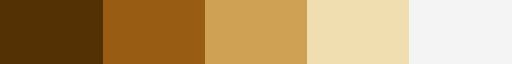

In [258]:
#make a new cmap that is a subset of an input, defined as percent of (eg. 10-60%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# just some testing so you can play around with the above 2 functions
cmap = discrete_cmap(6,truncate_colormap(cmap=colormaps['BrBG'],minval =0,maxval=.5, n=100))
#cmap = truncate_colormap(cmap=colormaps['BrBG'],minval =0,maxval=.5, n=100)
cmap

Latitude range: 20.90405 to 52.581223
Longitude range: -132.68779 to -62.91488
Correlation shape: (42, 66)
Lag shape: (42, 66)


/tmp/ipykernel_57193/1907205999.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
/tmp/ipykernel_57193/868682712.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust layout to give space for colorbar


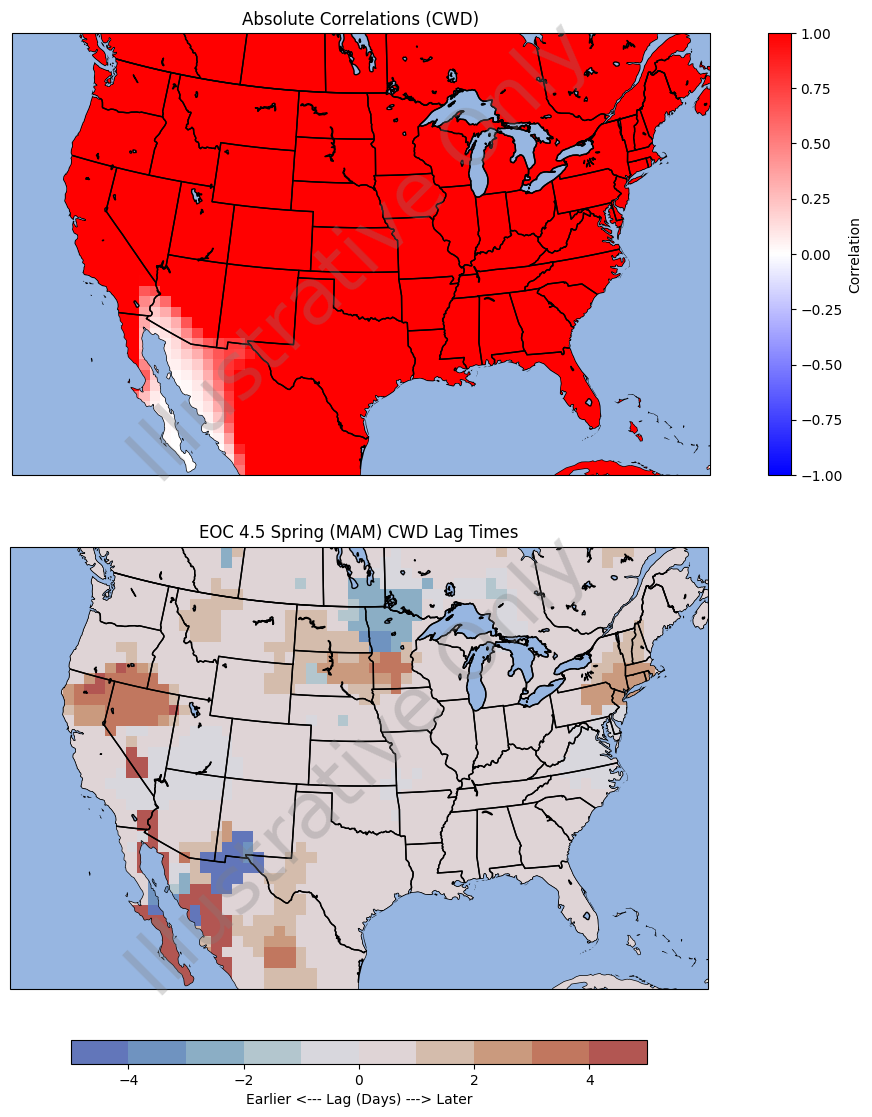

In [269]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_correlation_and_lags(correlation, lags, lon, lat):
    print("Latitude range:", lat.min(), "to", lat.max())
    print("Longitude range:", lon.min(), "to", lon.max())
    print("Correlation shape:", correlation.shape)
    print("Lag shape:", lags.shape)

    # Define the Lambert Conformal Conic projection centered on CONUS
    projection = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': projection})

    # Plot 1: Correlation plot
    corr_plot = ax1.pcolormesh(lon, lat, correlation, transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1, vmax=1)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_feature(cfeature.LAND, edgecolor='black')
    ax1.add_feature(cfeature.OCEAN, zorder=2)
    ax1.add_feature(cfeature.LAKES, edgecolor='black')
    ax1.add_feature(cfeature.STATES, edgecolor='black')
    ax1.set_title('Absolute Correlations (CWD)')
    fig.colorbar(corr_plot, ax=ax1, orientation='vertical', label='Correlation')

    # Add watermark to the first plot
    ax1.text(0.5, 0.5, 'Illustrative Only', transform=ax1.transAxes, fontsize=56, color='gray', 
             alpha=0.3, ha='center', va='center', rotation=45)

    # Plot 2: Lag plot
    custom_cmap = discrete_cmap(10,truncate_colormap(cmap=colormaps['twilight_shifted'],minval =.25,maxval=.75, n=100))
    
    lag_plot = ax2.pcolormesh(lon, lat, lags, transform=ccrs.PlateCarree(), cmap=custom_cmap, vmin=-5, vmax=5)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)
    ax2.add_feature(cfeature.LAND, edgecolor='black')
    ax2.add_feature(cfeature.OCEAN, zorder=2)
    ax2.add_feature(cfeature.LAKES, edgecolor='black')
    ax2.add_feature(cfeature.STATES, edgecolor='black')
    ax2.set_title('EOC 4.5 Spring (MAM) CWD Lag Times')

    # Create a new axis for the colorbar beneath the second plot, shrunk by 20%
    cax = fig.add_axes([0.26, 0.1, 0.48, 0.02])  # Shrink the width by 20% (originally 0.6)

    # Add the colorbar to this new axis
    plt.colorbar(lag_plot, cax=cax, orientation='horizontal', label='Earlier <--- Lag (Days) ---> Later')

    # Add watermark to the second plot
    plt.text(0.5, 0.5, 'Illustrative Only', transform=ax2.transAxes, fontsize=56, color='gray', 
             alpha=0.3, ha='center', va='center', rotation=45)

    plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust layout to give space for colorbar
    plt.show()

# Example usage
# Assuming baseline_da and future_da are your xarray DataArrays
correlation = compute_cross_correlation(baseline_da, future_da, kernel=kernel)
lags = compute_lag(baseline_da, future_da, kernel=kernel)

# Plotting
plot_correlation_and_lags(correlation, lags, baseline_da.lon.values, baseline_da.lat.values)
